In [422]:
import cvxpy as cp
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import time

In [410]:
def project_onto_density(sigma, rho, gamma, epsilon=1e-9):
    theta_min = -np.max(rho) + np.min(sigma)
    theta_max = np.max(sigma)
    theta_mid = None
    while theta_max - theta_min >= epsilon:
        theta_mid = (theta_max + theta_min) / 2
        rho_t = np.minimum(np.maximum(sigma-theta_mid,0),rho)
        if gamma < np.sum(rho_t):
            theta_min = theta_mid
        else:
            theta_max = theta_mid
    return np.minimum(np.maximum(sigma-theta_mid,0),rho)

def discrete_gradient(Phi, dx):
    n = Phi.shape[0]
    dPhi_x = (Phi[1:,:] - Phi[:-1,:]) / dx
    dPhi_y = (Phi[:,1:] - Phi[:,:-1]) / dx
    return dPhi_x, dPhi_y

def discrete_div(mx, my, dx):
    col0 = np.zeros((n,1))
    row0 = np.zeros((1,n))
    return (np.vstack((mx,row0))-np.vstack((row0,mx))+np.hstack((my,col0))-np.hstack((col0,my))) / dx

def shrink2(X, Y, mu, n):
    col0 = np.zeros((n,1))
    row0 = np.zeros((1,n))
    ghost = np.array([np.vstack((X, row0)), np.hstack((Y, col0))])
    norms = np.linalg.norm(ghost, axis=0)
    c = np.zeros_like(norms)
    for i in range(n):
        for j in range(n):
            if norms[i,j] >= mu:
                c[i,j] = 1-mu/norms[i,j]
    y = ghost*c
    return y[0,:-1,:], y[1,:,:-1]

def objective(mx, my, n):
    col0 = np.zeros((n,1))
    row0 = np.zeros((1,n))
    return np.sum(np.linalg.norm(np.vstack((np.hstack([my, col0]).reshape(1,-1), np.vstack([mx, row0]).reshape(1,-1))),axis=0))

def get_feasible(n, dx, gamma, p0, p1):
    mx = cp.Variable((n-1,n))
    my = cp.Variable((n,n-1))
    p0t = cp.Variable((n,n))
    p1t = cp.Variable((n,n))
    col0 = np.zeros((n,1))
    row0 = np.zeros((1,n))

    objective = cp.Minimize(1)

    # Assumes that p1t has larger mass
    constraints = [
        dx*(p0t - p1t) == cp.vstack([mx,row0])-cp.vstack([row0,mx])+cp.hstack([my,col0])-cp.hstack([col0,my]),
        p0t >= 0,
        p0t <= p0,
        p1t >= 0,
        p1t <= p1,
        cp.sum(p0t) == gamma,
        cp.sum(p1t) == gamma,
    ]
    prob = cp.Problem(objective, constraints)
    prob_val = prob.solve()
    return mx.value, my.value, p0t.value, p1t.value

In [421]:
def solve_with_cvxpy(gamma, p0, p1, n, dx):
    mx = cp.Variable((n-1,n))
    my = cp.Variable((n,n-1))
    p0t = cp.Variable((n,n))
    p1t = cp.Variable((n,n))
    col0 = np.zeros((n,1))
    row0 = np.zeros((1,n))

    objective = cp.Minimize(cp.sum(cp.norm(cp.vstack([cp.vec(cp.hstack([my, col0])), cp.vec(cp.vstack([mx, row0]))]),axis=0)))

    # Assumes that p1t has larger mass
    constraints = [
        dx*(p0t - p1t) == cp.vstack([mx,row0])-cp.vstack([row0,mx])+cp.hstack([my,col0])-cp.hstack([col0,my]),
        p0t >= 0,
        p0t <= p0,
        p1t >= 0,
        p1t <= p1,
        cp.sum(p0t) == gamma,
        cp.sum(p1t) == gamma,
    ]
    prob = cp.Problem(objective, constraints)
    prob_val = prob.solve()
    return prob_val, p0t.value, p1t.value, mx.value, my.value

In [431]:
def solve(rho0, rho1, gamma, rho00_t, rho10_t, m0, Phi0, dx, mu, nu, tau, n, eps=1e-10):
    start = time.time()
    m_list = [m0]
    rho0_t_list = [rho00_t]
    rho1_t_list = [rho10_t]
    Phi_list = [Phi0]
    objectives = []
    ct = 0
    while True:
        objectives.append(objective(m_list[-1][0], m_list[-1][1], n))
        if len(objectives) >= 2:
            if (np.abs(objectives[-1] - objectives[-2]) < eps):
                print("Iteration", ct, "Converged with objective value", objectives[-1])
                break
            elif ct % 1000 == 0:
                print("Iteration", ct, "Objective value is", objectives[-1])
            if ct >= 5e4:
                print("Stop")
                break
        ct += 1
        dPhi_x, dPhi_y = discrete_gradient(Phi_list[-1], dx)
        mx_next, my_next = shrink2(m_list[-1][0]+mu*dPhi_x, m_list[-1][1]+mu*dPhi_y, mu, n)
        rho0_t_next = project_onto_density(rho0_t_list[-1]+nu*Phi_list[-1], rho0, gamma)
        rho1_t_next = project_onto_density(rho1_t_list[-1]-nu*Phi_list[-1], rho1, gamma)
        Phi_next = Phi_list[-1] + tau*(
            discrete_div(2*mx_next - m_list[-1][0], 2*my_next - m_list[-1][1], dx)
             + 2*rho1_t_next - rho1_t_list[-1]
             - 2*rho0_t_next + rho0_t_list[-1]
        )
        m_list.append((mx_next, my_next))
        rho0_t_list.append(rho0_t_next)
        rho1_t_list.append(rho1_t_next)
        Phi_list.append(Phi_next)
    end = time.time()
    return m_list, rho0_t_list, rho1_t_list, Phi_list, objectives, end-start, ct

In [424]:
import gzip
f = gzip.open('train-images-idx3-ubyte.gz','r')

image_size = 28
num_images = 100

f.read(16)
buf = f.read(image_size * image_size * num_images)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data = data.reshape(num_images, image_size, image_size, 1)
image = np.asarray(data[4]).squeeze()
# plt.imshow(image)

In [425]:
# 3 and 8 are both 1s
rho1 = np.asarray(data[0]).squeeze()
rho0 = np.asarray(data[4]).squeeze()
assert np.sum(rho1) >= np.sum(rho0)
norm_factor = max(np.sum(rho1), np.sum(rho0))
rho1 = rho1 / norm_factor
rho0 = rho0 / norm_factor
print(np.sum(rho1), np.sum(rho0))

1.0 0.8433788


In [426]:
n = 28
dx = 1/(n - 1)
tau = 1e-2
gamma = 0.7
nu = 1/(4*tau)
mu = 1/(32*(n-1)**2*tau)

In [427]:
# mx, my, rho00t, rho10t = get_feasible(n, dx, gamma, rho0, rho1)
mx = np.random.normal(size=(n-1,n))
my = np.random.normal(size=(n,n-1))
rho0t = np.random.normal(size=(n,n))
rho1t = np.random.normal(size=(n,n))

In [432]:
m, rho0t, rho1t, Phi, objs, solve_time, num_iters = solve(rho0, rho1, gamma, rho00t, rho10t, (mx, my), np.random.normal(size=(n,n)), dx, mu, nu, tau, n, eps=1e-12)

Iteration 1000 Objective value is 0.0011489816732225826
Iteration 2000 Objective value is 0.002274969583461343
Iteration 3000 Objective value is 0.002732268514063844
Iteration 4000 Objective value is 0.003106916062563242
Iteration 5000 Objective value is 0.0032976730478180573
Iteration 6000 Objective value is 0.003426564025503217
Iteration 7000 Objective value is 0.0036739324981070252
Iteration 8000 Objective value is 0.0039037285413128344
Iteration 9000 Objective value is 0.003940165505885789
Iteration 10000 Objective value is 0.003961088995428322
Iteration 11000 Objective value is 0.003977338878198891
Iteration 12000 Objective value is 0.004009080432500325
Iteration 13000 Objective value is 0.004021085113062527
Iteration 14000 Objective value is 0.004036644634624982
Iteration 15000 Objective value is 0.004048003186891869
Iteration 16000 Objective value is 0.004062008154927512
Iteration 17000 Objective value is 0.0040690221671839735
Iteration 18000 Objective value is 0.004075689665217

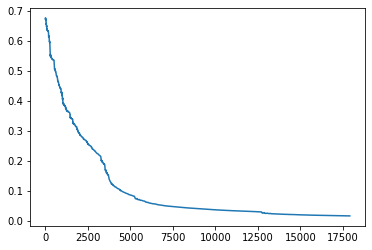

In [417]:
plt.plot((np.array([np.sum(np.abs((rho0t[i]-rho1t[i])-discrete_div(m[i][0],m[i][1],dx))) for i in range(len(rho0t))]))[1000:])

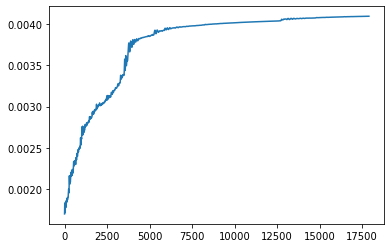

In [418]:
plt.plot(objs[1000:])